## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [2]:
#референс для ДЗ
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [3]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [4]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [5]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

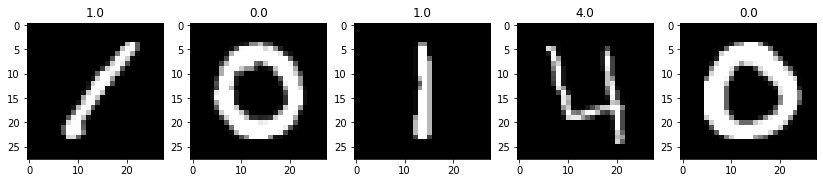

In [6]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [7]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [8]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [9]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [10]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

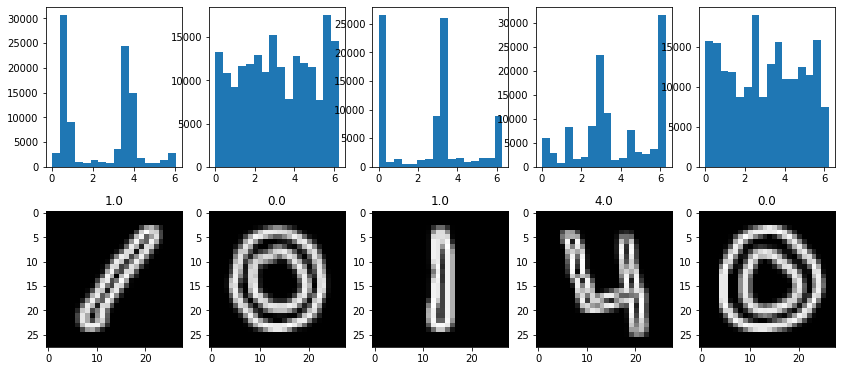

In [11]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [12]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [13]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [14]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [15]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [16]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

In [23]:
x_train.shape

(33600, 16)

## Обучение модели

In [29]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

model = RandomForestClassifier()

model.fit(x_train, y_train)

pred_val = model.predict(x_val)
accuracy_score(pred_val, y_val)

0.6452380952380953

## Вычисляем центроиды каждого из 10 классов

In [30]:
# centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [31]:
# for i in range(10):
#     centroids[i] = np.mean(x_train[y_train == i], axis=0)

## Находим ближайший центройд для валидации

In [32]:
# pred_val = np.zeros_like(y_val)
# for i in range(len(y_val)):
#     distances = np.linalg.norm(centroids - x_val[i], axis=1)
#     pred_val[i] = np.argmin(distances)

## Оцениваем качество решение на валидационной выборке

In [33]:
# from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.6452380952380953


In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.43      0.41      0.42       816
         1.0       0.97      0.96      0.97       909
         2.0       0.48      0.47      0.47       846
         3.0       0.66      0.68      0.67       937
         4.0       0.72      0.69      0.70       839
         5.0       0.63      0.65      0.64       702
         6.0       0.49      0.47      0.48       785
         7.0       0.86      0.81      0.83       893
         8.0       0.51      0.56      0.53       835
         9.0       0.66      0.69      0.67       838

    accuracy                           0.65      8400
   macro avg       0.64      0.64      0.64      8400
weighted avg       0.65      0.65      0.65      8400



In [35]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[335   5  66  29  34  18 113  11 166  39]
 [  1 875   2   0  19   0   2   5   0   5]
 [ 63   0 397 123   4  99  56  13  75  16]
 [ 19   0  96 640   0  84  10   5  75   8]
 [ 23  13  13   2 576   0  82  35   7  88]
 [  7   0  84 107   0 459   8   5  29   3]
 [135   1  62  10  62   6 370  12  68  59]
 [  7   4  31   5  42  13  17 721   5  48]
 [141   0  50  48   7  37  44   4 467  37]
 [ 45   2  29  12  54   7  59  24  26 580]]


## Предсказания на тестовых данных

In [41]:
# pred_test = np.zeros(len(test_img), np.uint8)
# for i in range(len(test_img)):
#     distances = np.linalg.norm(centroids - test_hist[i], axis=1)
#     pred_test[i] = np.argmin(distances)
pred_test = model.predict(test_hist).astype(int)

## Визуализируем предсказания

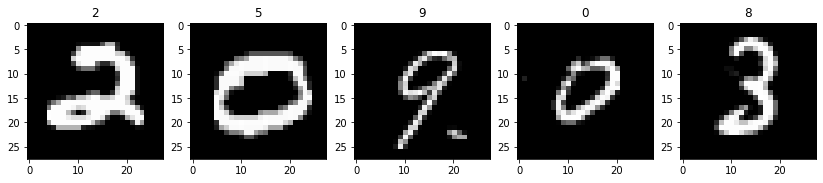

In [42]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [43]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [44]:
!head submit.txt

ImageId,Label
1,2
2,5
3,9
4,0
5,8
6,7
7,0
8,3
9,3


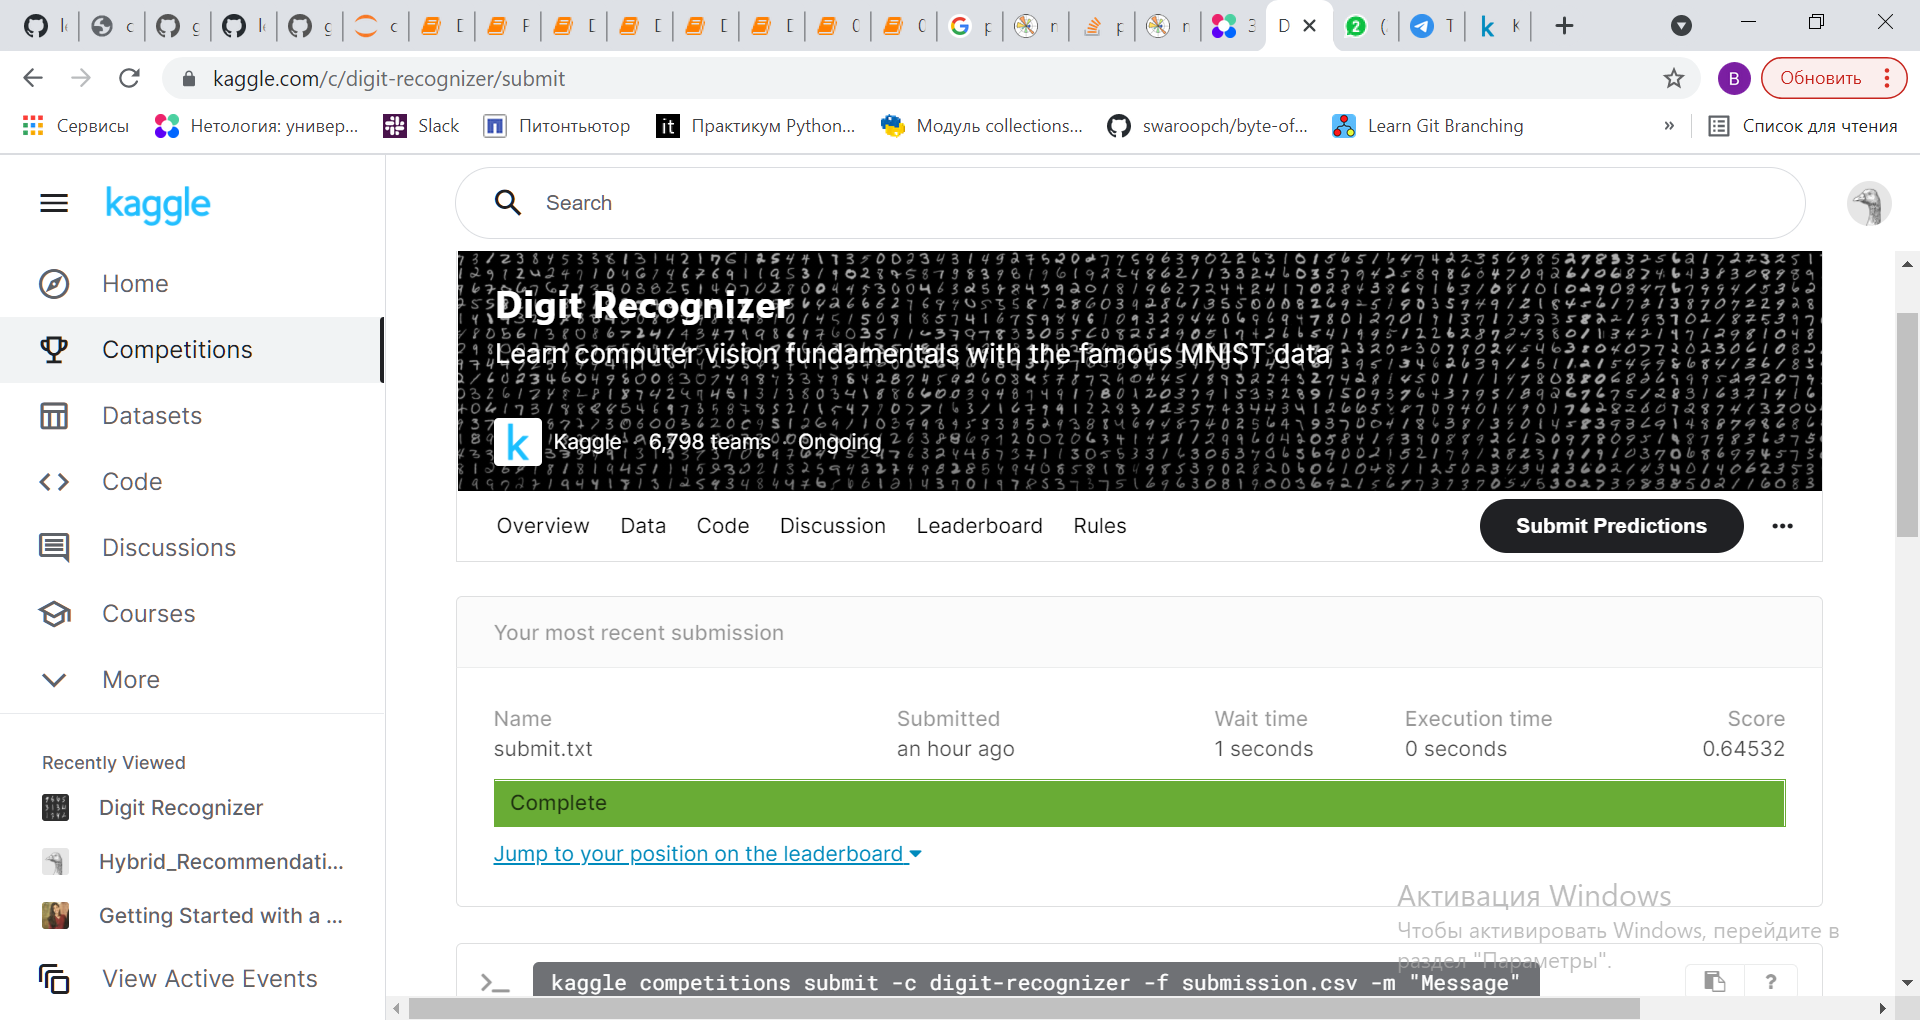

In [45]:
from IPython.display import Image
Image('Vera_Romantsova_score.png')